# Hierarchical Kriging Demo

In [56]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('../src')

from mfmodel.kriging import Kriging
from mfmodel.mfkriging import MFKriging

## 1. High and low fidelity functions

We use bifidelity analytical example from [1] to generate artificial high and low fidelity data.

[1] Meng, X., & Karniadakis, G. E. (2020). A composite neural network that learns from multi-fidelity data: Application to function approximation and inverse PDE problems. Journal of Computational Physics, 401, 109020.

In [57]:
# function parameters
a = 0.5
b = 10
c = -5

# high fidelity function
def f_high(x):
    return a*(6*x-2)**2 * np.sin(12*x-4) + b*(x-0.5) + c

# low fidelity function
def f_low(x):
    return (6*x-2)**2 * np.sin(12*x-4)

(100, 1)


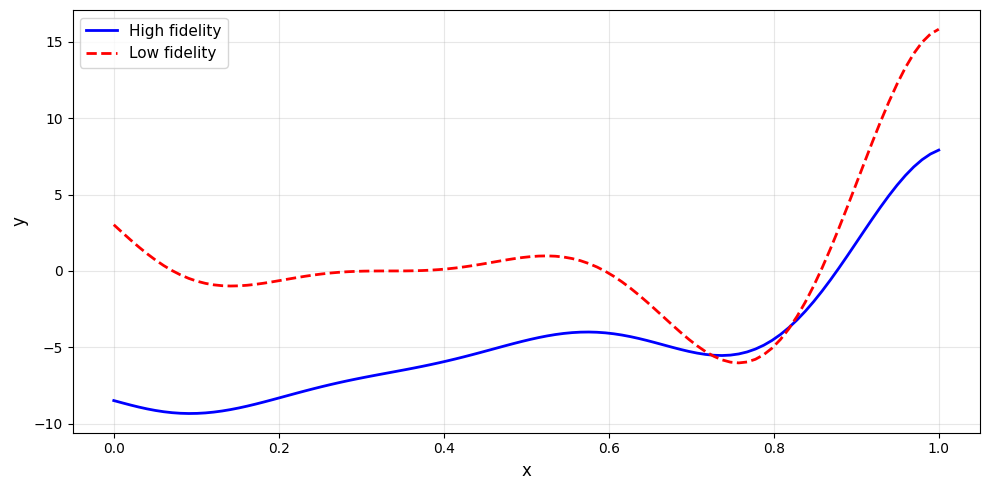

In [58]:
x_plot = np.linspace(0, 1, 100).reshape(-1,1)
y_high_true = f_high(x_plot)
y_low_true = f_low(x_plot)
print(y_high_true.shape)

plt.figure(figsize=(10, 5))
plt.plot(x_plot, y_high_true, 'b-', linewidth=2, label='High fidelity')
plt.plot(x_plot, y_low_true, 'r--', linewidth=2, label='Low fidelity')
plt.xlabel('x', fontsize=12)
plt.ylabel('y', fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 2. Single fidelity Kriging

In [59]:
# generate training samples for single fidelity kriging

np.random.seed(100)
n_sf = 7  # budget
x_train_sf = np.random.uniform(0, 1, n_sf).reshape(-1, 1)
y_train_sf = f_high(x_train_sf.ravel()).reshape(-1, 1)

print(f"Number of single fidelity training samples: {n_sf}")

Number of single fidelity training samples: 7


In [60]:
# train single fidelity kriging model
sf_model = Kriging(kernel='ardmatern32', regularize=True, normalize=True, n_restart=5)
sf_model.train(x_train_sf, y_train_sf)
print("Single fidelity model trained.")

# predict on test points
x_test = x_plot.reshape(-1, 1)
y_pred_sf, var_pred_sf = sf_model.predict(x_test, return_var=True)
std_pred_sf = np.sqrt(np.abs(var_pred_sf)).ravel()

Single fidelity model trained.


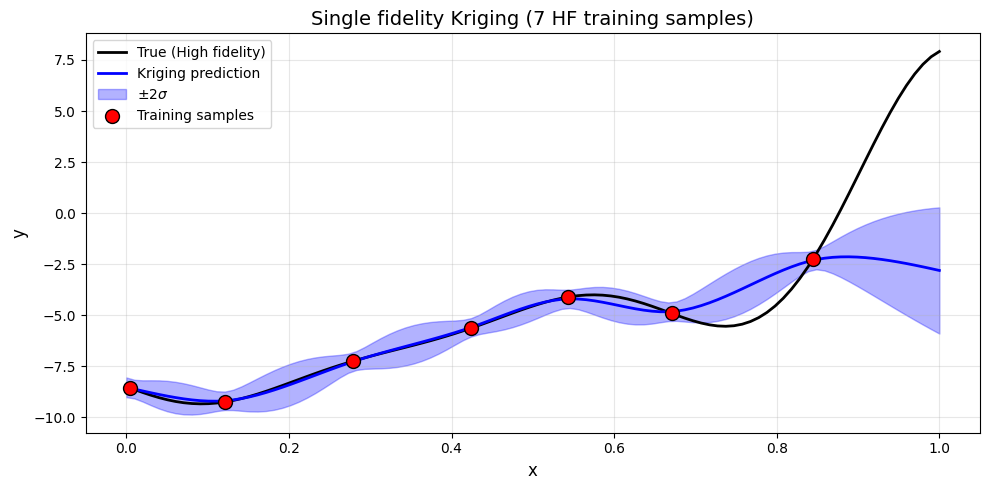

In [61]:
# Plot single fidelity kriging prediction
plt.figure(figsize=(10, 5))
plt.plot(x_plot, y_high_true, 'k-', linewidth=2, label='True (High fidelity)')
plt.plot(x_plot, y_pred_sf.ravel(), 'b-', linewidth=2, label='Kriging prediction')
plt.fill_between(x_plot.ravel(), 
                 y_pred_sf.ravel() - 2*std_pred_sf, 
                 y_pred_sf.ravel() + 2*std_pred_sf, 
                 alpha=0.3, color='blue', label=r'$\pm 2\sigma$')
plt.scatter(x_train_sf.ravel(), y_train_sf.ravel(), 
            c='red', s=100, zorder=5, edgecolors='black', label='Training samples')
plt.xlabel('x', fontsize=12)
plt.ylabel('y', fontsize=12)
plt.title(f'Single fidelity Kriging ({n_sf} HF training samples)', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 3. Hierarchical Kriging with MFMC Allocation

In [62]:
import h5py
import os
from mfmc import MFMC

# set up
budget = n_sf      # total budget
w1 = 1.0    # high fidelity cost
w2 = 0.1    # low fidelity cost
cost = np.array([w1, w2])

# Step 1: Compute statistics
n_samples_stat = 1000
x_stat = np.random.uniform(0, 1, n_samples_stat)
y_h_stat = f_high(x_stat).reshape(-1, 1)
y_l_stat = f_low(x_stat).reshape(-1, 1)
os.makedirs('../../data/demo', exist_ok=True)
with h5py.File('../../data/demo/highfi.h5', 'w') as f:
    f.create_dataset('output', data=y_h_stat)
with h5py.File('../../data/demo/lowfi.h5', 'w') as f:
    f.create_dataset('output', data=y_l_stat)
mfmc = MFMC('../../data/demo/highfi.h5', '../../data/demo/lowfi.h5', cost)
sigma, rho = mfmc.stats()

# Step 2: Allocate samples using MFMC
m, const = mfmc.alloc(sigma, rho, budget)
n_high = int(m[0])
n_low = int(m[1])
print(f"MFMC Statistics:")
print(f"standard deviation = {sigma}")
print(f"correlation coefficient = {rho[:-1]}")
print(f"MFMC allocation = {const[1]:.2f}")
print(f"n (HF samples) = {n_high}")
print(f"m (LF samples) = {n_low}")
print(f"Actual budget used: {n_high*w1 + n_low*w2:.2f}")

# Generate nested samples: HF is a subset of LF
np.random.seed(101)
# generate LF samples
x_train_low = np.random.uniform(0, 1, n_low).reshape(-1, 1)
y_train_low = f_low(x_train_low.ravel()).reshape(-1, 1)

# generate HF samples (set first n_high points from LF as training data)
x_train_high = x_train_low[:n_high]
y_train_high = f_high(x_train_high.ravel()).reshape(-1, 1)

MFMC Statistics:
standard deviation = [4.22271768 4.63400749]
correlation coefficient = [1.         0.76184574]
MFMC allocation = 3.72
n (HF samples) = 5
m (LF samples) = 18
Actual budget used: 6.80


In [63]:
# Train hierarchical kriging model
mf_model = MFKriging(kernel='ardmatern32', regularize=True, normalize=True, n_restart=5)
mf_model.train(x_train_low, y_train_low, x_train_high, y_train_high)
print("Hierarchical kriging model trained.")

# Predict on test points
y_pred_mf, var_pred_mf = mf_model.predict(x_test, return_var=True)
std_pred_mf = np.sqrt(np.abs(var_pred_mf)).ravel()


Hierarchical kriging model trained.


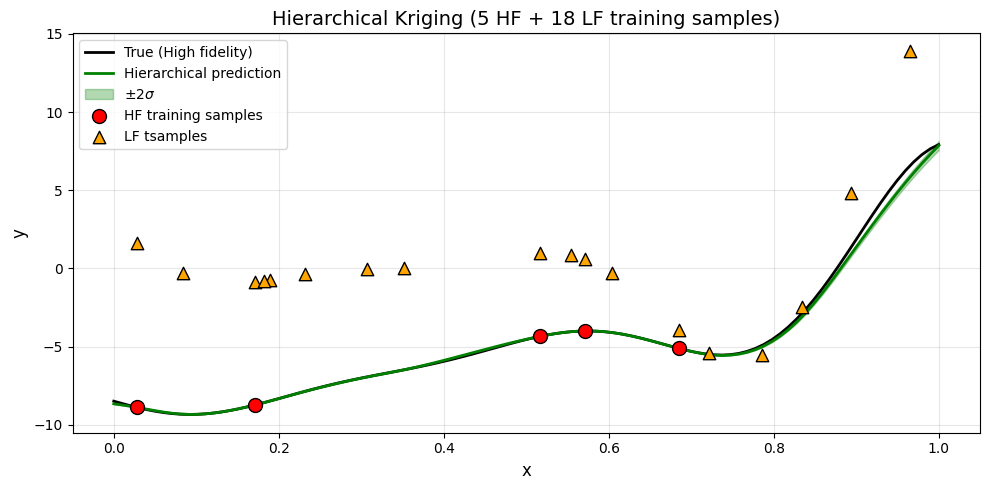

In [64]:
# Plot hierarchical kriging prediction
plt.figure(figsize=(10, 5))
plt.plot(x_plot, y_high_true, 'k-', linewidth=2, label='True (High fidelity)')
plt.plot(x_plot, y_pred_mf.ravel(), 'g-', linewidth=2, label='Hierarchical prediction')
plt.fill_between(x_plot.ravel(), 
                 y_pred_mf.ravel() - 2*std_pred_mf, 
                 y_pred_mf.ravel() + 2*std_pred_mf, 
                 alpha=0.3, color='green', label=r'$\pm 2\sigma$')
plt.scatter(x_train_high.ravel(), y_train_high.ravel(), 
            c='red', s=100, zorder=5, edgecolors='black', label='HF training samples')
plt.scatter(x_train_low.ravel(), y_train_low.ravel(), 
            c='orange', s=80, zorder=4, edgecolors='black', marker='^', label='LF tsamples')
plt.xlabel('x', fontsize=12)
plt.ylabel('y', fontsize=12)
plt.title(f'Hierarchical Kriging ({n_high} HF + {n_low} LF training samples)', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 4. Comparison: Single-Fidelity vs Hierarchical Kriging

In [65]:
# Compute relative error for both models
from postprocess import relerr

rel_err_sf = relerr(y_high_true, y_pred_sf)
rel_err_mf = relerr(y_high_true, y_pred_mf)

print(f"Single-Fidelity Kriging ({n_sf} HF training samples):")
print(f"  Relative Error = {rel_err_sf:.4f}")
print(f"\nHierarchical Kriging ({n_high} HF + {n_low} LF training samples):")
print(f"  Relative Error = {rel_err_mf:.4f}")

Single-Fidelity Kriging (7 HF training samples):
  Relative Error = 0.4215

Hierarchical Kriging (5 HF + 18 LF training samples):
  Relative Error = 0.0532
